<a href="https://colab.research.google.com/github/jdasam/aat3020-2023/blob/main/notebooks/3_Language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


/home/teo/.local/share/virtualenvs/aat3020-2023-E1AG9i7b/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
!wget "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

--2023-04-18 14:43:11--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-04-18 14:43:11 (8.15 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
def read_txt(txt_path):
  with open(txt_path, 'r') as f:
    txt_string = f.readlines()
  return txt_string

txt_string = read_txt('names.txt')

In [5]:
names = [x[:-1] for x in txt_string]
len(names)

32033

In [6]:
# 2-gram 
entire_ngram = []
n = 5

for name in names:
  len_name = len(name)
  for i in range(len(name)-(n-1)):
    n_gram = name[i:i+n]
    entire_ngram.append(n_gram)

In [7]:
from collections import Counter

n_gram_counter = Counter(entire_ngram)

In [8]:
# how many combination exists?
len(n_gram_counter)

147692

In [9]:
n_gram_counter.most_common(10)

[('     ', 644349),
 ('    <', 128843),
 ('-line', 128145),
 ('blob-', 128144),
 ('line-', 96132),
 ('er js', 96113),
 ('r js-', 96113),
 ('-code', 96106),
 ('   <t', 96106),
 ('umber', 96102)]

In [10]:
n_gram_keys = sorted(list(n_gram_counter.keys()))
n_gram_keys

['     ',
 '    "',
 '    &',
 '    2',
 '    3',
 '    <',
 '    >',
 '    A',
 '    B',
 '    C',
 '    D',
 '    E',
 '    F',
 '    G',
 '    H',
 '    I',
 '    J',
 '    M',
 '    O',
 '    P',
 '    R',
 '    S',
 '    T',
 '    U',
 '    V',
 '    W',
 '    Y',
 '    a',
 '    c',
 '    d',
 '    f',
 '    h',
 '    i',
 '    k',
 '    n',
 '    p',
 '    q',
 '    r',
 '    s',
 '    t',
 '   &c',
 '   22',
 '   32',
 '   <!',
 '   </',
 '   <a',
 '   <b',
 '   <c',
 '   <d',
 '   <f',
 '   <h',
 '   <i',
 '   <l',
 '   <m',
 '   <n',
 '   <p',
 '   <r',
 '   <s',
 '   <t',
 '   <u',
 '   A ',
 '   Ac',
 '   Al',
 '   Au',
 '   Bl',
 '   CI',
 '   Ca',
 '   Co',
 '   Cr',
 '   Cu',
 '   De',
 '   Do',
 '   Ed',
 '   En',
 '   Fi',
 '   Fu',
 '   Gi',
 '   Go',
 '   Ho',
 '   In',
 '   Is',
 '   Ju',
 '   Ma',
 '   Op',
 '   Pl',
 '   Pr',
 '   Pu',
 '   Re',
 '   Se',
 '   Sh',
 '   Si',
 '   So',
 '   St',
 '   Te',
 '   Th',
 '   To',
 '   Tr',
 '   Us',
 '   Vi',
 '   Wr',


In [ ]:
n_gram_counter['ab']

541

In [ ]:
starting_characters = list(set([x[0] for x in n_gram_keys]))

example_chr = starting_characters[0]
example_chr
corresp_ngram_words = [x for x in n_gram_keys if x[0] == example_chr]
total_chr_appearance = sum([n_gram_counter[word] for word in corresp_ngram_words])

prob_of_words = [n_gram_counter[x]/total_chr_appearance for x in corresp_ngram_words]


In [ ]:
prob_of_words

In [ ]:
starting_characters = sorted(list(set([x[0] for x in n_gram_keys])))
len(starting_characters)

26

In [ ]:
# Make transition matrix
import numpy as np

transition = np.zeros([26, 26], dtype=np.int)
chrs = sorted(list(set([x[0] for x in n_gram_keys])))
chrs

In [ ]:
for i, start in enumerate(chrs):
  for j, end in enumerate(chrs):
    transition[i, j] = n_gram_counter[start+end]

In [ ]:
import torch

transition = torch.tensor(transition)
torch.set_printoptions(sci_mode=False)

In [ ]:
trans_prob = transition / transition.sum(dim=1).unsqueeze(1)
trans_prob

In [ ]:
trans_prob[0].sum()

tensor(1.)

In [ ]:
chrs[16], chrs[20], trans_prob[16, 20]

('q', 'u', tensor(0.8443))

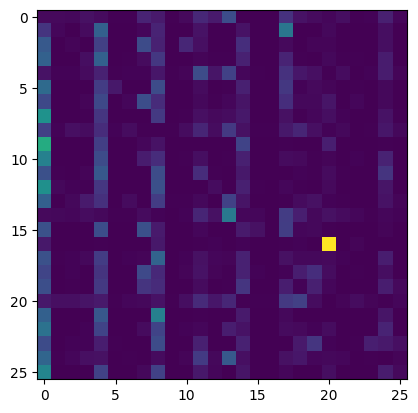

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(trans_prob)

## Neural Network

In [6]:
import torch
import torch.nn

class Dataset:
  def __init__(self, list_of_names):
    self.names = list_of_names
    self.chrs = sorted(list(set([chr  for name in self.names for chr in name])))
    self.chrs = ['0', '.'] + self.chrs
    self.tok2idx = {chr:i for i, chr in enumerate(self.chrs)}

  def __len__(self):
    return len(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]
    name = '.' + name + '.'
    name_in_indices = [self.tok2idx[chr] for chr in name]
    return torch.tensor(name_in_indices, dtype=torch.long)

dataset = Dataset(names)
dataset[0]

tensor([ 1,  6, 14, 14,  2,  1])

In [ ]:
vocab_size = len(dataset.chrs)
emb_dim = 8

word_emb = nn.Embedding(vocab_size, emb_dim)

In [ ]:
word_emb.weight[0]

tensor([ 1.9232,  1.1801, -0.0887, -0.5216, -0.7418,  0.1340,  0.1982,  1.7162],
       grad_fn=<SelectBackward0>)

In [ ]:
name_tensor = dataset[0]
emb = word_emb(name_tensor)

In [ ]:
emb.shape

torch.Size([4, 8])

In [ ]:
emb[0:1]

tensor([[-0.2799, -0.2369, -0.8305, -0.0751, -0.0813, -0.6871,  0.9136, -0.5130]],
       grad_fn=<SliceBackward0>)

In [ ]:
hidden_size = 12
weight_xh = nn.Linear(emb_dim, hidden_size, bias=False)

weight_xh(emb)

tensor([[ 0.2765,  0.0718, -0.2240,  0.4251, -0.5079,  0.0619,  0.1541,  0.1498,
          0.1081,  0.1318, -0.1567,  0.6033],
        [-0.3789, -0.7592,  0.6421,  0.0938,  0.9305,  0.0575, -0.2183,  0.6115,
          0.2539, -0.6574,  1.3094, -0.2639],
        [-0.3789, -0.7592,  0.6421,  0.0938,  0.9305,  0.0575, -0.2183,  0.6115,
          0.2539, -0.6574,  1.3094, -0.2639],
        [-0.8022,  0.0042, -0.6203,  0.0713, -0.3739, -0.1618,  0.5518, -0.1413,
         -0.8806, -1.0042,  0.1083,  0.2116]], grad_fn=<MmBackward0>)

In [ ]:
weight_hh = nn.Linear(hidden_size, hidden_size)

initial_hidden = torch.zeros(hidden_size)

$h_1 = \sigma(W_{hh}h_{0} + W_{xh}x_{1})$


In [ ]:
next_hidden = (weight_hh(initial_hidden) + weight_xh(emb[0:1])).tanh()
next_hidden

tensor([[-0.0100,  0.3083,  0.0411,  0.3529, -0.4464, -0.2156,  0.1012,  0.0840,
          0.0386,  0.0354, -0.3462,  0.5948]], grad_fn=<TanhBackward0>)

In [ ]:
timestep = 0
hidden = torch.zeros(hidden_size)
total_hidden = []

for t in range(len(name_tensor)):
  emb_t = word_emb(name_tensor[t])
  hidden = (weight_hh(hidden) + weight_xh(emb_t)).tanh()
  total_hidden.append(hidden)
total_hidden

[tensor([-0.0100,  0.3083,  0.0411,  0.3529, -0.4464, -0.2156,  0.1012,  0.0840,
          0.0386,  0.0354, -0.3462,  0.5948], grad_fn=<TanhBackward0>),
 tensor([-0.5425, -0.4924,  0.7898, -0.0250,  0.8380, -0.2019, -0.0767,  0.5737,
          0.2884, -0.7382,  0.6682, -0.2965], grad_fn=<TanhBackward0>),
 tensor([-0.4872, -0.8018,  0.3790,  0.2149,  0.7639, -0.6407, -0.6718,  0.5409,
          0.2854, -0.3986,  0.9189,  0.4143], grad_fn=<TanhBackward0>),
 tensor([-0.8312, -0.5261, -0.6565,  0.2503, -0.6020, -0.7073,  0.2114, -0.5513,
         -0.5902, -0.7046, -0.0567,  0.7878], grad_fn=<TanhBackward0>)]

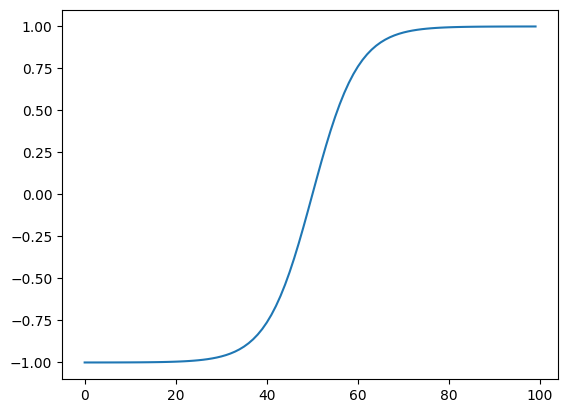

In [ ]:
import matplotlib.pyplot as plt
plt.plot(((torch.arange(100) - 50)/10).tanh())

# Language Model

In [7]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.RNN(emb_dim, hidden_size, num_layers=1, batch_first=True)
    self.proj = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    emb = self.emb(x)
    out, _ = self.rnn(emb)
    out = self.proj(out)
    return out
  
dataset = Dataset(names)

vocab_size = len(dataset.chrs)
emb_dim = 16
hidden_size = 32
model = LanguageModel(vocab_size, emb_dim, hidden_size)
  

In [15]:
def get_nll(pred, target):
  pred = pred.reshape(-1, pred.shape[-1])
  target = target.reshape(-1)
  pred_masked = pred[target!=0]
  target_masked = target[target!=0]
  
  return -torch.log(pred_masked[torch.arange(len(target_masked)), target_masked] + 1e-8).mean()

In [16]:
def pad_collate_fn(batch):
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
  return batch

In [20]:

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn)

model = LanguageModel(vocab_size, emb_dim, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.train()
dev = 'cuda'
# dev='cpu'
model.to(dev)
loss_fn = get_nll
n_epoch = 10
loss_record = []

for epoch in range(10):
  for batch in tqdm(dataloader, leave=False):
    batch = batch.to(dev)
    x = batch[:, :-1]
    y = batch[:, 1:]
    
    optimizer.zero_grad()
    out = model(x)
    loss = loss_fn(out.softmax(dim=-1), y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


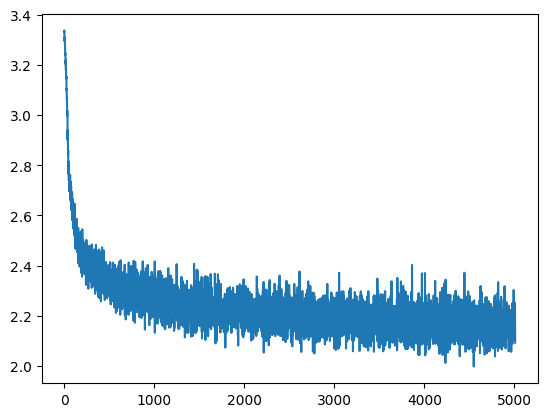

In [21]:
plt.plot(loss_record)